In [1]:
import os
import json
import random
import requests
import platform
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# TF-Serving RESTful API informations: https://www.tensorflow.org/tfx/serving/api_rest
# Docker informations: https://www.docker.com

In [3]:
# Check OS informations, docker version

resp = !docker --version
docker_version = ' '.join(resp[0].split(' ')[2:])
print("Current OS: \n"
      "    {}\n".format(platform.platform()))
print("Docker version: \n"
      "    {}".format(docker_version))

Current OS: 
    Darwin-18.7.0-x86_64-i386-64bit

Docker version: 
    19.03.8, build afacb8b


In [4]:
# Prepare testing data

mnist = tf.keras.datasets.mnist
(_, _), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype(np.astype(np.float32)), x_test.astype(np.astype(np.float32))
x_test /= 255.

In [5]:
# Print MNIST dataset informations
# 打印 MNIST 資料集相關資訊

print("Images numbers:\n"
        "     Test : {}".format(x_test.shape[0]))
print("Image size: {} * {}".format(x_test.shape[1:][0], x_test.shape[1:][1]))

Images numbers:
     Test : 10000
Image size: 28 * 28


In [6]:
# Pull tf-serving latest official image from docker hub 
# Or use !docker pull tensorflow/serving:1.12.0 to pull specific version
# Use gpu with tensorflow/serving:latest-gpu
# 從 docker hub 拉取最新的 tf-serving 映像檔
# 或是使用 !docker pull tensorflow/serving:1.12.0 拉取特定版本
# Gpu 版本請用 tensorflow/serving:latest-gpu

!docker pull tensorflow/serving:latest

latest: Pulling from tensorflow/serving
Digest: sha256:ea44bf657f8cff7b07df12361749ea94628185352836bb08065345f5c8284bae
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest


In [ ]:
# Run serving docker, better not run this shit in IPython notebook
# 請打開一個終端已架設 serving docker，別使用 IPython notebook

!$MODELPATH = "Your models folder path ... must be absolute path!"
!docker run -t --rm -p 8501:8501 \
    --mount type=bind,source=$MODELPATH,target=/models \
    -e MODEL_NAME=mnist \
    --name serving_test \
    tensorflow/serving

In [7]:
# You can get informations of served model with API after you successfully ran a serving docker
# 如果成功跑起一個 serving docker，可以用 API 取得模型資訊

!curl http://localhost:8501/v1/models/mnist

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}


In [8]:
# One of the key advantages of REST APIs is that they provide a great deal of flexibility
# Data is not tied to resources or methods, so REST can handle multiple types of calls
# Use python request lib

resp = requests.get('http://localhost:8501/v1/models/mnist')
print(resp.text)

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}



In [9]:
# Get model metadata that we can easily know the signatures in model

resp = requests.get('http://localhost:8501/v1/models/mnist/metadata')
print("Status code: \n"
      "         {}".format(resp))
print("Respones: \n"
      "         {}".format(resp.text))

Status code: 
         <Response [200]>
Respones: 
         {
"model_spec":{
 "name": "mnist",
 "signature_name": "",
 "version": "1"
}
,
"metadata": {"signature_def": {
 "signature_def": {
  "serving_default": {
   "inputs": {
    "flatten_input": {
     "dtype": "DT_FLOAT",
     "tensor_shape": {
      "dim": [
       {
        "size": "-1",
        "name": ""
       },
       {
        "size": "28",
        "name": ""
       },
       {
        "size": "28",
        "name": ""
       }
      ],
      "unknown_rank": false
     },
     "name": "serving_default_flatten_input:0"
    }
   },
   "outputs": {
    "dense_1": {
     "dtype": "DT_FLOAT",
     "tensor_shape": {
      "dim": [
       {
        "size": "-1",
        "name": ""
       },
       {
        "size": "10",
        "name": ""
       }
      ],
      "unknown_rank": false
     },
     "name": "StatefulPartitionedCall:0"
    }
   },
   "method_name": "tensorflow/serving/predict"
  },
  "__saved_model_init_op": {
   "inp

In [10]:
# Test inference by first ten test cases

test = x_test[:10].tolist()
test_json = {
    "instances": test
}
print("Type of request data:\n"
      "               {}".format(type(test_json)))

resp = requests.post("http://localhost:8501/v1/models/mnist:predict", json=test_json)

print("Type of request response:\n"
      "               {}".format(type(resp)))

Type of request data:
               <class 'dict'>
Type of request response:
               <class 'requests.models.Response'>


Prediction result of first test data:
[[0.0, 6.71813315e-33, 1.61362728e-16, 1.62005649e-13, 7.61437364e-21, 1.19216396e-22, 0.0, 1.0, 0.0, 9.4720408e-15]]


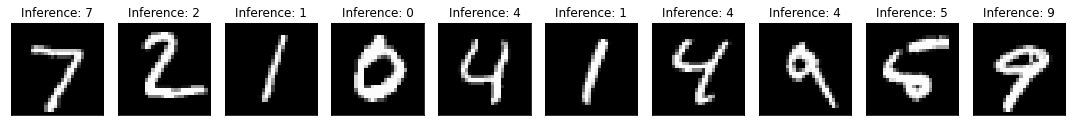

In [11]:
# Get json string from inference response

predictions = resp.json()['predictions']

# Scores of 10 classes 0 ~ 9

print("Prediction result of first test data:\n"
      "{}".format(predictions[0:1]))

# Display test image and serving inference

example_num = 10
plt.figure(figsize=(15, 15))
for i in range(0, example_num):
    plt.subplot(9,10,i + 1)
    plt.title("Inference: {}".format(np.argmax(predictions[i])))
    plt.imshow(x_test[i], cmap ='gray', )
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()